<a href="https://colab.research.google.com/github/amina-mardiyyah/BioHackathon_25/blob/main/Biohackathon25_curate_to_iob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# restart runtime after running the cell below

In [1]:
%%capture
!pip install uv
!uv pip install loguru
!uv pip install scispacy spacy==3.7.5 "numpy<2"
!uv pip install datasets==3.0.2
!uv pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz

In [1]:
#import necessary packages
import pandas as pd
from ast import literal_eval
from tqdm import tqdm
from typing import Union, Dict, List
from collections import Counter

import spacy
import scispacy

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from loguru import logger
from datasets import Dataset, load_dataset, DatasetDict


In [65]:
#import data
bio_annot = pd.read_csv("biohackathon_raw_v2.csv")
print(bio_annot.shape)
bio_annot.head()

(2470, 10)


,PMCID,Title,annotation_id,annotator,created_at,id,label,lead_time,text,updated_at
0,PMC5779697,Adipose tissue ATGL modifies the cardiac lipid...,92,6,2025-12-03T11:08:21.884940Z,2057,"[{""start"":0,""end"":24,""text"":""Adipose tissue li...",340.925,Adipose tissue lipolysis occurs during the dev...,2025-12-03T11:08:21.884977Z
1,PMC5779697,Adipose tissue ATGL modifies the cardiac lipid...,4,1,2025-12-03T09:44:20.309976Z,2057,"[{""start"":0,""end"":24,""text"":""Adipose tissue li...",511.063,Adipose tissue lipolysis occurs during the dev...,2025-12-03T12:51:06.256775Z
2,PMC5779697,Adipose tissue ATGL modifies the cardiac lipid...,192,6,2025-12-03T12:45:05.259520Z,2058,"[{""start"":32,""end"":39,""text"":""adipose"",""labels...",621.303,"However, the impact of enhanced adipose triacy...",2025-12-03T12:45:05.259556Z
3,PMC5779697,Adipose tissue ATGL modifies the cardiac lipid...,190,6,2025-12-03T12:44:57.940052Z,2058,"[{""start"":32,""end"":39,""text"":""adipose"",""labels...",621.303,"However, the impact of enhanced adipose triacy...",2025-12-03T12:44:57.940086Z
4,PMC5779697,Adipose tissue ATGL modifies the cardiac lipid...,201,6,2025-12-03T12:47:42.190768Z,2059,"[{""start"":59,""end"":72,""text"":""heart failure"",""...",121.815,To investigate the role of adipose tissue lipo...,2025-12-03T12:47:42.190810Z


In [66]:
#ids are duplicated. We can see how many times below
bio_annot.id.value_counts()

,count
id,
7379,11
13424,4
14690,4
2737,3
2742,3
...,...
3855,1
3854,1
3853,1


In [67]:
#get total duplicated entries
bio_annot.duplicated(subset=["id"]).sum()

153

In [68]:
#drop duplicated entries and only keep last occurence.
bio_annot.drop_duplicates(subset=["id"], inplace=True, keep='last')
bio_annot.shape

(2317, 10)

In [69]:
bio_annot.columns

Index(['PMCID', 'Title', 'annotation_id', 'annotator', 'created_at', 'id',
       'label', 'lead_time', 'text', 'updated_at'],
      dtype='object')

In [70]:
#retrieve only necessary columns
bio_annot = bio_annot[["PMCID", "text", "label"]]
print(bio_annot.shape)
bio_annot.head()

(2317, 3)


,PMCID,text,label
1,PMC5779697,Adipose tissue lipolysis occurs during the dev...,"[{""start"":0,""end"":24,""text"":""Adipose tissue li..."
3,PMC5779697,"However, the impact of enhanced adipose triacy...","[{""start"":32,""end"":39,""text"":""adipose"",""labels..."
5,PMC5779697,To investigate the role of adipose tissue lipo...,"[{""start"":59,""end"":72,""text"":""heart failure"",""..."
6,PMC5779697,atATGL-KO mice were subjected to transverse ao...,"[{""start"":0,""end"":9,""text"":""atATGL-KO"",""labels..."
7,PMC5779697,The cardiac mouse lipidome and the human plasm...,"[{""start"":162,""end"":190,""text"":""MS-based shotg..."


In [72]:
bio_annot.PMCID.unique()

array(['PMC5779697', 'PMC8259984', 'PMC10469212', 'PMC11269705',
       'PMC10902711', 'PMC11458896', 'PMC10728066', 'PMC6097988',
       'PMC9599481', 'PMC8342504', 'PMC7417482', 'PMC5050431',
       'PMC8521299', 'PMC5339821', 'PMC8755711', 'PMC10776612',
       'PMC7897626', 'PMC6128551', 'PMC9352691', 'PMC3954792',
       'PMC6760179', 'PMC7592055', 'PMC7449968', 'PMC9011034',
       'PMC10175254', 'PMC4906355'], dtype=object)

In [73]:
bio_annot.PMCID.nunique()

26

In [74]:
all_pmcids = list(bio_annot.PMCID.unique())

In [75]:
#check example labels. Labels are represented as strings instead of list
bio_annot.label.iloc[0]

'[{"start":0,"end":24,"text":"Adipose tissue lipolysis","labels":["Disease"]},{"start":58,"end":71,"text":"heart failure","labels":["Disease"]},{"start":92,"end":123,"text":"chronic adrenergic stimulation.","labels":["Function"]},{"start":0,"end":14,"text":"Adipose tissue","labels":["Tissue"]}]'

In [76]:
bio_annot.label.iloc[1]

'[{"start":32,"end":39,"text":"adipose","labels":["Tissue"]},{"start":40,"end":55,"text":"triacylglycerol","labels":["Lipid"]},{"start":117,"end":133,"text":"cardiac function","labels":["Function"]},{"start":79,"end":113,"text":"adipose triglyceride lipase (ATGL)","labels":["Protein"]},{"start":56,"end":66,"text":"hydrolysis","labels":["Function"]}]'

In [77]:
#check for missing values
bio_annot.isnull().sum()

,0
PMCID,0
text,0
label,384


In [78]:
bio_annot[bio_annot.label.isnull()]

,PMCID,text,label
72,PMC5779697,G: LVM relative to tibia length (LVM/TL).,NaN
73,PMC5779697,H: Left-ventricular internal diameter in diast...,NaN
74,PMC5779697,I: Ejection fraction [%] (EF).,NaN
75,PMC5779697,J: Fractional shortening [%] (FS).,NaN
77,PMC5779697,Data are presented as x-fold over wt-sham mice...,NaN
...,...,...,...
2463,PMC4906355,"Mean values of anthropometric (BMI, WHR, body ...",NaN
2464,PMC4906355,Do lipid concentrations only reflect apparent ...,NaN
2465,PMC4906355,To answer this question we built a correlation...,NaN
2466,PMC4906355,We observed that clinical indices only associa...,NaN


In [79]:
#missing values are unannotated part of the texts. We'll fill missing values with empty list []
bio_annot.fillna("[]", inplace=True)
bio_annot.isnull().sum()

,0
PMCID,0
text,0
label,0


In [80]:
bio_annot.shape

(2317, 3)

In [81]:
#preprocessing functions to format label column into standard spacy format
def flatten_singleton_labels(entities_lst, ent_label_key="labels"):

    if not isinstance(entities_lst, list):
        raise ValueError(f"Expected List of Dictionaries but got : {type(entities_lst)}")
    cleaned_entities_lst = []
    for ent in entities_lst:
        if isinstance(ent, dict) and ent_label_key in ent and isinstance(ent[ent_label_key] , list) and len(ent[ent_label_key]) == 1:
            cleaned_ent = ent.copy()
            cleaned_ent[ent_label_key] = cleaned_ent[ent_label_key][0]
            cleaned_entities_lst.append(cleaned_ent)
        else:
            cleaned_entities_lst.append(ent)

    return cleaned_entities_lst


def convert_str_2_lst(col):
    """
    Converts a string representation of a list back to an actual list.
    If the input is not a string representation of a list, it returns the input unchanged.
    Args:
        col (a str or pandas Dataframe col): Input that may be a string representation of a list.
    Returns:
        list or any: The converted list if input was a string representation of a list, otherwise the original input.
    """
    if isinstance(col, str) and col.startswith("[") and col.endswith("]"):
        return literal_eval(col)
    else:
        return col


In [82]:
#1. Convert label column from str to list
bio_annot["label"] = bio_annot["label"].apply(convert_str_2_lst)

#2. Flat single element list to a str i.e from "labels":["Function"]} to "labels":"Function"}
bio_annot["label"] = bio_annot["label"].apply(lambda x: [] if isinstance(x, float) else x)
bio_annot["label"] = bio_annot["label"].apply(flatten_singleton_labels)

#check example again after preprocessing
bio_annot.label.iloc[1]


<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: inv

[{'start': 32, 'end': 39, 'text': 'adipose', 'labels': 'Tissue'},
 {'start': 40, 'end': 55, 'text': 'triacylglycerol', 'labels': 'Lipid'},
 {'start': 117, 'end': 133, 'text': 'cardiac function', 'labels': 'Function'},
 {'start': 79,
  'end': 113,
  'text': 'adipose triglyceride lipase (ATGL)',
  'labels': 'Protein'},
 {'start': 56, 'end': 66, 'text': 'hydrolysis', 'labels': 'Function'}]

In [83]:
len(bio_annot.label.iloc[0])

4

In [84]:
bio_annot.reset_index(drop=True, inplace=True)
bio_annot.head()

,PMCID,text,label
0,PMC5779697,Adipose tissue lipolysis occurs during the dev...,"[{'start': 0, 'end': 24, 'text': 'Adipose tiss..."
1,PMC5779697,"However, the impact of enhanced adipose triacy...","[{'start': 32, 'end': 39, 'text': 'adipose', '..."
2,PMC5779697,To investigate the role of adipose tissue lipo...,"[{'start': 59, 'end': 72, 'text': 'heart failu..."
3,PMC5779697,atATGL-KO mice were subjected to transverse ao...,"[{'start': 0, 'end': 9, 'text': 'atATGL-KO', '..."
4,PMC5779697,The cardiac mouse lipidome and the human plasm...,"[{'start': 162, 'end': 190, 'text': 'MS-based ..."


In [85]:
bio_annot.query("label.str.len() < 1")

,PMCID,text,label
64,PMC5779697,G: LVM relative to tibia length (LVM/TL).,[]
65,PMC5779697,H: Left-ventricular internal diameter in diast...,[]
66,PMC5779697,I: Ejection fraction [%] (EF).,[]
67,PMC5779697,J: Fractional shortening [%] (FS).,[]
69,PMC5779697,Data are presented as x-fold over wt-sham mice...,[]
...,...,...,...
2310,PMC4906355,"Mean values of anthropometric (BMI, WHR, body ...",[]
2311,PMC4906355,Do lipid concentrations only reflect apparent ...,[]
2312,PMC4906355,To answer this question we built a correlation...,[]
2313,PMC4906355,We observed that clinical indices only associa...,[]


In [86]:
bio_annot.label.iloc[69]

[]

In [87]:
def filter_ent(ent_list, relevant_ent):
    """
    Keep only entities with relevant labels: CellLine, CellType, Tissue.
    Handles casing and whitespace.
    """
    relevant_ent = {x.strip().lower() for x in relevant_ent}
    return [
        ent for ent in ent_list
        if ent.get("labels", "").strip().lower() in relevant_ent
    ]

In [88]:

def count_unique_entities(df: pd.DataFrame):
    """
    Counts unique entity label occurrences in a dataframe where df['labels']
    is a list of dictionaries with key 'labels'.

    Returns a dictionary {entity_type: count}.
    """
    counter = Counter()

    for label_list in df["label"]:
        if not isinstance(label_list, list):
            continue

        for ann in label_list:
            ent_label = ann.get("labels")
            if ent_label:
                counter[ent_label] += 1

    return dict(counter)

In [89]:
label_counts = count_unique_entities(bio_annot)
label_counts

{'Disease': 892,
 'Function': 510,
 'Tissue': 1028,
 'Lipid': 2731,
 'Protein': 588,
 'Organism': 428,
 'Organism Variant': 301,
 'Assay Type': 632,
 'Metabolite': 355,
 'CellType': 134,
 'Gene': 28,
 'Process': 36,
 'LABEL_0': 636,
 'LABEL_1': 636}

In [90]:
del label_counts["LABEL_1"]
del label_counts["LABEL_0"]

label_df = pd.DataFrame(list(label_counts.items()), columns=["Entity", "Count"])
label_df

,Entity,Count
0,Disease,892
1,Function,510
2,Tissue,1028
3,Lipid,2731
4,Protein,588
5,Organism,428
6,Organism Variant,301
7,Assay Type,632
8,Metabolite,355
9,CellType,134


/tmp/ipython-input-1311786513.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


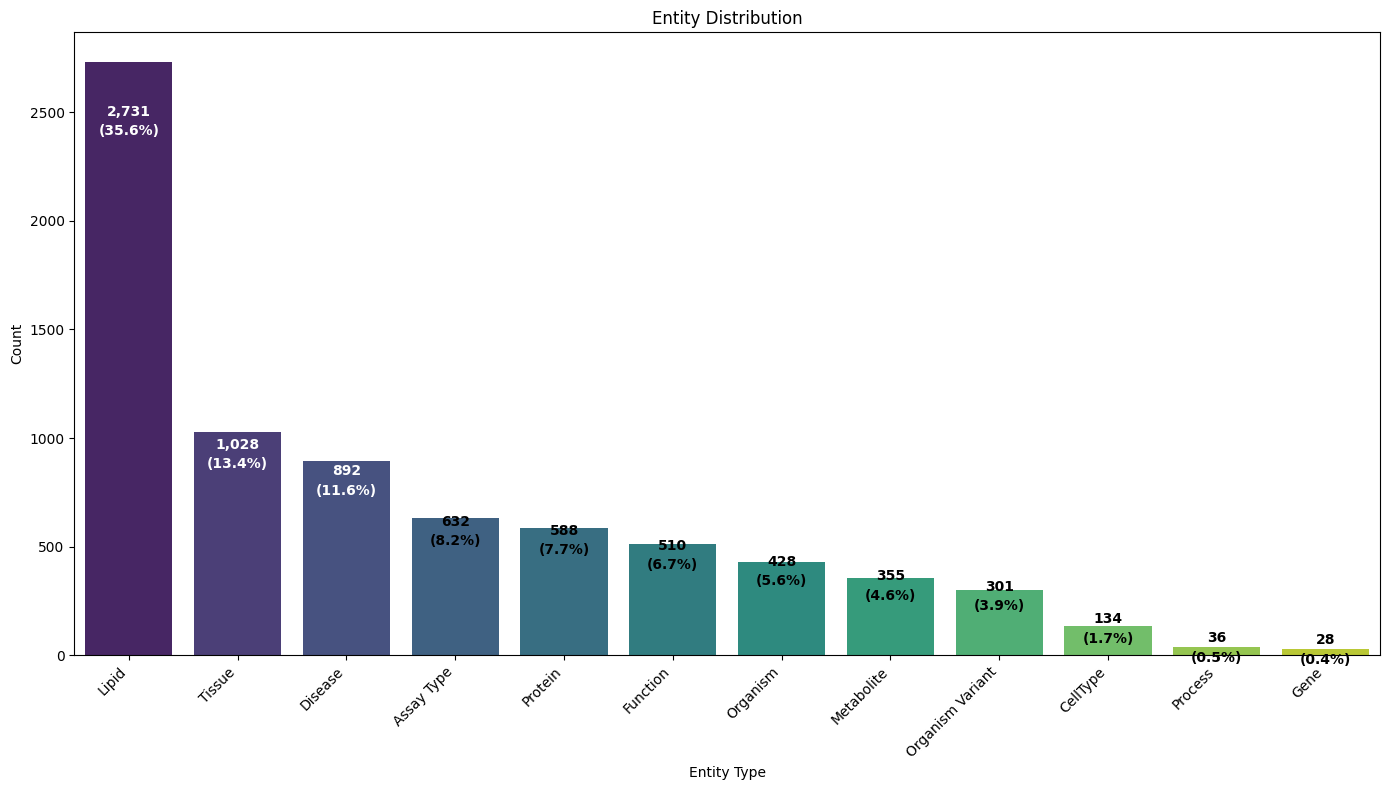

In [91]:

# Sort the data
label_df_ = label_df.sort_values(by="Count", ascending=False)
total = label_df_["Count"].sum()
label_df_["Percentage"] = label_df_["Count"] / total * 100

plt.figure(figsize=(14, 8))

# Create the bar plot
ax = sns.barplot(
    data=label_df_,
    x="Entity",
    y="Count",
    palette="viridis"
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels - CORRECTED for vertical bars
for i, (index, row) in enumerate(label_df_.iterrows()):
    # For vertical bars: position text just below the top of each bar
    text_y = row["Count"] - (row["Count"] * 0.10)  # 5% below the top

    # Determine text color based on bar height
    text_color = "white" if row["Count"] > total * 0.1 else "black"

    ax.text(
        i,  # x-coordinate: entity index
        text_y,  # y-coordinate: height position
        f"{row['Count']:,}\n({row['Percentage']:.1f}%)",
        va="center",
        ha="center",  # Center text horizontally in the bar
        fontsize=10,
        color=text_color,
        fontweight="bold",
        linespacing=1.5
    )

plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.title("Entity Distribution")
plt.tight_layout()
plt.show()

In [92]:
relevant_ent = {x.lower() for x in list(label_counts.keys())}
relevant_ent

{'assay type',
 'celltype',
 'disease',
 'function',
 'gene',
 'lipid',
 'metabolite',
 'organism',
 'organism variant',
 'process',
 'protein',
 'tissue'}

In [93]:
#filter irrelevant labels e.g Label0 and Label1 from data
bio_annot["label"] = bio_annot["label"].apply(lambda x : filter_ent(x, relevant_ent=relevant_ent))


In [94]:
#split data on PMCIDs into train and val 80:20 ratio
train_ratio = 0.8
train_pmcids = all_pmcids[:int(train_ratio*len(all_pmcids))]
val_pmcids = all_pmcids[int(train_ratio*len(all_pmcids)):]
len(train_pmcids), len(val_pmcids)

(20, 6)

In [96]:
train_df = bio_annot[bio_annot.PMCID.isin(train_pmcids)]
print(train_df.shape)
train_df.head()

(1881, 3)


,PMCID,text,label
0,PMC5779697,Adipose tissue lipolysis occurs during the dev...,"[{'start': 0, 'end': 24, 'text': 'Adipose tiss..."
1,PMC5779697,"However, the impact of enhanced adipose triacy...","[{'start': 32, 'end': 39, 'text': 'adipose', '..."
2,PMC5779697,To investigate the role of adipose tissue lipo...,"[{'start': 59, 'end': 72, 'text': 'heart failu..."
3,PMC5779697,atATGL-KO mice were subjected to transverse ao...,"[{'start': 0, 'end': 9, 'text': 'atATGL-KO', '..."
4,PMC5779697,The cardiac mouse lipidome and the human plasm...,"[{'start': 162, 'end': 190, 'text': 'MS-based ..."


In [97]:
val_df = bio_annot[bio_annot.PMCID.isin(val_pmcids)]
print(val_df.shape)
val_df.head()

(436, 3)


,PMCID,text,label
1881,PMC6760179,Understanding genetic architecture of plasma l...,"[{'start': 38, 'end': 44, 'text': 'plasma', 'l..."
1882,PMC6760179,"Here, we perform genome-wide association analy...","[{'start': 135, 'end': 138, 'text': 'CVD', 'la..."
1883,PMC6760179,We identify 35 lipid-species-associated loci (...,"[{'start': 84, 'end': 87, 'text': 'CVD', 'labe..."
1884,PMC6760179,We identify loci for lipid species that are sh...,"[{'start': 61, 'end': 64, 'text': 'CVD', 'labe..."
1885,PMC6760179,We show that lipoprotein lipase (LPL) may more...,"[{'start': 13, 'end': 37, 'text': 'lipoprotein..."


In [98]:
#load spacy model for creating IOB schema
nlp = spacy.load("en_core_sci_md", disable=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"])
nlp.add_pipe("sentencizer")
nlp.max_length = 10_000_000

/usr/local/lib/python3.12/dist-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/usr/local/lib/python3.12/dist-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/usr/local/lib/python3.12/dist-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/usr/local/lib/python3.12/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [100]:
#function reference: https://github.com/ML4LitS/OTAR3088/blob/main/Entity-Extraction-Modular-pipeline/steps/tokenize_preprocess.py

def convert2iob(
    data: Union[str, Dict, List[Dict], pd.Series, pd.DataFrame],
    entities: List[Dict] = None,
    nlp:scispacy=nlp,
    ent_label_key: str = "labels",
    return_hf: bool = False
) -> Union[Dict, List[Dict], Dataset]:
    """
    Convert sentences + entities into IOB format.

    Accepts:
    - text as single str and entities as list of dict e.g "Stem cells are amazing", [{"start": 0, "end": 10, "label": "CellType"}]
    - dict with keys sentence(value:str), entities(value:list) e.g {"sentence": str, "entities": [...]}
    - list of dicts(standard spacy annotation format): e.g `[{'sentence': 'Human embryonic stem cells.....','entities': [{'start':, 'end': , 'labels': '},{'start': , 'end': , 'labels': ''},....]
    - pandas row (Series) with 'sentence' and 'entities'. Can also be used as an apply function to a dataframe e.g `df.apply(lambda row: convert2iob(row), axis=1)`
    - pandas DataFrame with 'sentence' and 'entities'. Pass dataframe directly as `convert2iob(df)

    Args:
        data: input data
        entities: required only if `data` is a string
        nlp: spaCy model (must be provided)
        ent_label_key: which key holds entity labels ("label" or "labels")
        return_hf: if True, returns HuggingFace Dataset object

    Returns:
        - HuggingFace Dataset if return_hf=True otherwise list of dicts: {"tokens":[], "tags":[]}
    """

    if nlp is None:
        raise ValueError("Please provide a loaded spaCy model to `nlp`")


    results = None

    # Case 1: list of dicts
    if isinstance(data, list) and all(isinstance(item, dict) for item in data):
      results = [_process_sentence(item["text"], item["label"], ent_label_key, nlp) for item in data]

    # Case 2: single dict
    elif isinstance(data, dict) and "text" in data and "label" in data:
      results = [_process_sentence(data["text"], data["label"], ent_label_key, nlp)]

    # Case 3: pandas series
    elif isinstance(data, pd.Series) and "text" in data and "label" in data:
      results = [_process_sentence(data["text"], data["label"], ent_label_key, nlp)]

    # Case 4: pandas DataFrame
    elif isinstance(data, pd.DataFrame):
      if not {"text", "label"}.issubset(data.columns):
        raise ValueError("Expected DataFrame to contain 'text' and 'label' columns")
      results = [_process_sentence(row["text"], row["label"], ent_label_key, nlp) for _, row in data.iterrows()]

    # Case 5: raw string + entities
    elif isinstance(data, str) and entities is not None:
      results = [_process_sentence(data, entities, ent_label_key, nlp)]

    else:
      raise ValueError("Unsupported input format for convert2iob()")

    # Convert to HF dataset if set to True
    if return_hf:
      return Dataset.from_list(results)

    # Return single dict if only one item
    return results if len(results) > 1 else results[0]



def _process_sentence(sent: str, ents: List[Dict], ent_label_key:str,nlp:scispacy) -> Dict:
    # Tokenize sentence
    doc = nlp(sent)
    tokens = [tok.text for tok in doc]
    offsets = [(tok.idx, tok.idx + len(tok.text)) for tok in doc]

    # Initialise all tags as 'O'
    tags = ["O"] * len(tokens)

    # Assign IOB tags
    for ent in ents:
        start, end = ent["start"], ent["end"]
        entity = ent.get(ent_label_key)
        if entity is None:
            raise KeyError(f"Entity dict missing expected entity key '{ent_label_key}'")

        for i, (token_start, token_end) in enumerate(offsets):
            if token_start >= start and token_end <= end:
                tags[i] = f"B-{entity}" if token_start == start else f"I-{entity}"

    return {"tokens": tokens, "tags": tags}

In [104]:
#create hugginface dataset for train and val
hf_train = convert2iob(train_df, return_hf=True)
hf_val = convert2iob(val_df, return_hf=True)
hf_train


Dataset({
    features: ['tokens', 'tags'],
    num_rows: 1881
})

In [102]:
#check sample
hf_train[0]

{'tokens': ['Adipose',
  'tissue',
  'lipolysis',
  'occurs',
  'during',
  'the',
  'development',
  'of',
  'heart',
  'failure',
  'as',
  'a',
  'consequence',
  'of',
  'chronic',
  'adrenergic',
  'stimulation',
  '.'],
 'tags': ['B-Tissue',
  'I-Tissue',
  'I-Disease',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Disease',
  'I-Disease',
  'O',
  'O',
  'O',
  'O',
  'B-Function',
  'I-Function',
  'I-Function',
  'I-Function']}

In [105]:
#merge train and val and push to hugginface
hf_ds = DatasetDict({"train":hf_train,
                     "validation":hf_val})
hf_ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1881
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 436
    })
})

In [106]:
hf_ds.push_to_hub("BioHackathon_25_IOB_V1", commit_message="Update V1 Biohackathon Dataset with train-validation split")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.


README.md:   0%|          | 0.00/312 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Mardiyyah/BioHackathon_25_IOB_V1/commit/2010f3804a7eda5cc2a402ad4a7a3b8b758b1568', commit_message='Update V1 Biohackathon Dataset with train-validation split', commit_description='', oid='2010f3804a7eda5cc2a402ad4a7a3b8b758b1568', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Mardiyyah/BioHackathon_25_IOB_V1', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Mardiyyah/BioHackathon_25_IOB_V1'), pr_revision=None, pr_num=None)